In [49]:
import os
import numpy as np
import pandas as pd
import librosa
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns

In [50]:
# Update base path to your dataset in Colab
import kagglehub

# Download latest version
base_path = kagglehub.dataset_download("pranaykoppula/torgo-audio")


In [51]:
def load_audio_files(base_path):
    """
    Load audio files from TORGO dataset directories

    Args:
        base_path (str): Root directory of the TORGO dataset

    Returns:
        list: Paths to audio files
        list: Corresponding labels
    """
    audio_files = []
    labels = []
    subdirs = ['F_Con', 'F_Dys', 'M_Con', 'M_Dys']

    for subdir in tqdm(subdirs, desc="Processing Directories"):
        current_path = os.path.join(base_path, subdir)
        label = 'Dysarthric' if 'Dys' in subdir else 'Control'
        for root, dirs, files in os.walk(current_path):
            for file in tqdm(files, desc=f"Scanning {subdir}", leave=False):
                if file.endswith('.wav'):
                    file_path = os.path.join(root, file)
                    audio_files.append(file_path)
                    labels.append(label)
    return audio_files, labels


In [52]:
def extract_mfcc(file_path, duration=3, sr=16000, n_mfcc=40):
    try:
        y, sr = librosa.load(file_path, sr=sr, duration=duration)
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfcc = np.mean(mfcc.T, axis=0)
        return mfcc
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

In [53]:
def prepare_feature_vectors(audio_files, labels):
    mfcc_features = []
    dataset_labels = []
    le = LabelEncoder()
    encoded_labels = le.fit_transform(labels)
    for file_path, label in tqdm(zip(audio_files, encoded_labels), total=len(audio_files), desc="Extracting MFCC Features"):
        features = extract_mfcc(file_path)
        if features is not None:
            mfcc_features.append(features)
            dataset_labels.append(label)
    if len(mfcc_features) == 0:
        raise RuntimeError("No valid features extracted. Please check your data and feature extraction process.")
    X_mfcc = torch.tensor(mfcc_features, dtype=torch.float32)
    y = torch.tensor(dataset_labels)
    return X_mfcc, y

In [54]:
class SimpleCNN(nn.Module):
    def __init__(self, input_dim=40, output_dim=2):
        super(SimpleCNN, self).__init__()
        self.network = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Conv1d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Linear(32 * (input_dim // 4), 128),
            nn.ReLU(),
            nn.Linear(128, output_dim),
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        return self.network(x)

In [55]:
def train_cnn_model(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleCNN(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training CNN Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    # Performance Metrics
    acc = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average="macro")
    recall = recall_score(all_true, all_preds, average="macro")
    f1 = f1_score(all_true, all_preds, average="macro")

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    class_names = ["Control", "Dysarthric"]
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)

    return model, class_report, conf_matrix, acc, precision, recall, f1

In [56]:
# Plot Confusion Matrix
def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()


# Plot Bar Chart for Metrics
def plot_bar_chart(metrics, techniques):
    plt.figure(figsize=(10, 6))
    x = np.arange(len(techniques))
    width = 0.2

    plt.bar(x - width, metrics["accuracy"], width, label="Accuracy")
    plt.bar(x, metrics["f1_score"], width, label="F1-Score")

    plt.xticks(x, techniques)
    plt.ylabel("Score")
    plt.title("Accuracy and F1-Score Comparison")
    plt.legend()
    plt.show()


# Radar Chart for Metrics
def plot_radar_chart(precision, recall, f1, classes):
    angles = np.linspace(0, 2 * np.pi, len(classes), endpoint=False).tolist()
    angles += angles[:1]  # Close the loop

    precision += precision[:1]
    recall += recall[:1]
    f1 += f1[:1]

    fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

    ax.fill(angles, precision, color="r", alpha=0.25, label="Precision")
    ax.fill(angles, recall, color="g", alpha=0.25, label="Recall")
    ax.fill(angles, f1, color="b", alpha=0.25, label="F1-Score")

    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(classes)

    ax.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
    plt.title("Precision, Recall, and F1-Score Comparison")
    plt.show()

In [57]:
print("Loading Audio Files")
audio_files, labels = load_audio_files(base_path)
print(f"Total audio files found: {len(audio_files)}")

Loading Audio Files


Processing Directories:   0%|          | 0/4 [00:00<?, ?it/s]
Scanning F_Con: 0it [00:00, ?it/s]
                                  
Scanning F_Con:   0%|          | 0/387 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/390 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/208 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/164 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/400 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/269 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/405 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/256 [00:00<?, ?it/s]
                            

Total audio files found: 17635



Preparing Feature Vectors


Extracting MFCC Features:  13%|█▎        | 2325/17635 [00:30<02:54, 87.71it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Extracting MFCC Features:  29%|██▉       | 5176/17635 [01:05<01:58, 105.09it/s]<ipython-input-52-d646d60f1af5>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting MFCC Features:  29%|██▉       | 5199/17635 [01:05<01:56, 107.06it/s]

Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 
Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


Extracting MFCC Features:  94%|█████████▍| 16603/17635 [03:26<00:12, 85.97it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=939
  warnings.warn(
Extracting MFCC Features:  94%|█████████▍| 16633/17635 [03:27<00:10, 91.40it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=134
  warnings.warn(
Extracting MFCC Features:  95%|█████████▍| 16673/17635 [03:27<00:10, 92.92it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=421
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=155
  warnings.warn(
Extracting MFCC Features:  95%|█████████▍| 16683/17635 [03:27<00:10, 89.11it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py

Feature matrix shape: torch.Size([17633, 40])
Labels shape: torch.Size([17633])

Training CNN Model


Training CNN Model: 100%|██████████| 50/50 [01:59<00:00,  2.39s/it]


Accuracy: 0.9861
Precision: 0.9855
Recall: 0.9839
F1-Score: 0.9847

Classification Report:
              precision    recall  f1-score   support

     Control       0.99      0.99      0.99      2291
  Dysarthric       0.98      0.98      0.98      1236

    accuracy                           0.99      3527
   macro avg       0.99      0.98      0.98      3527
weighted avg       0.99      0.99      0.99      3527



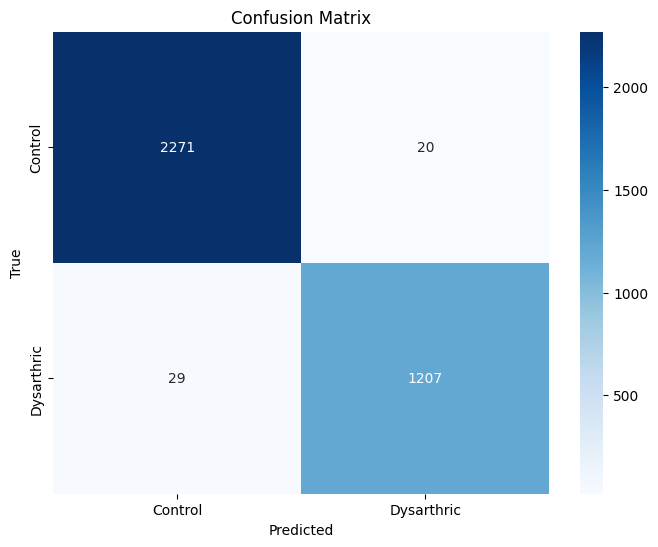

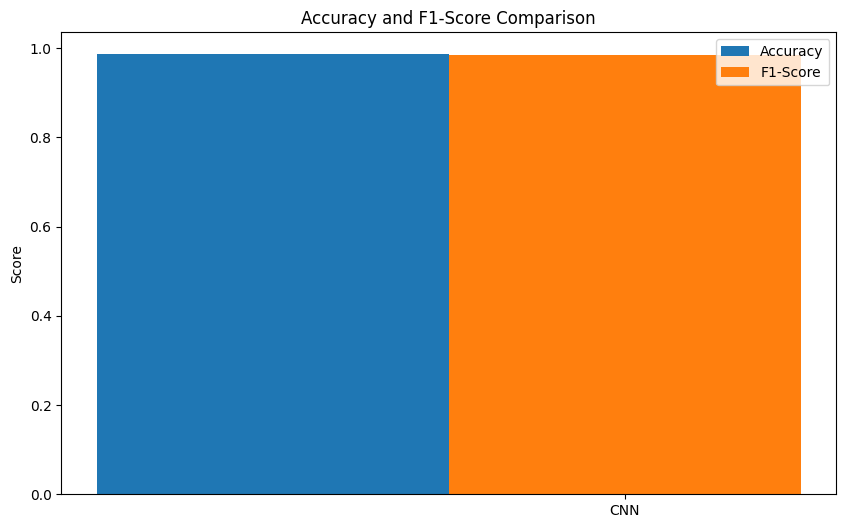

<ipython-input-58-b03c5c83320a>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  precision_per_class = [precision_score(y, model(torch.tensor(X)).argmax(1).cpu(), average=None)]
<ipython-input-58-b03c5c83320a>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  recall_per_class = [recall_score(y, model(torch.tensor(X)).argmax(1).cpu(), average=None)]
<ipython-input-58-b03c5c83320a>:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  f1_per_class = [f1_score(y, model(torch.tensor(X)).argmax(1).cpu(), average=None)]


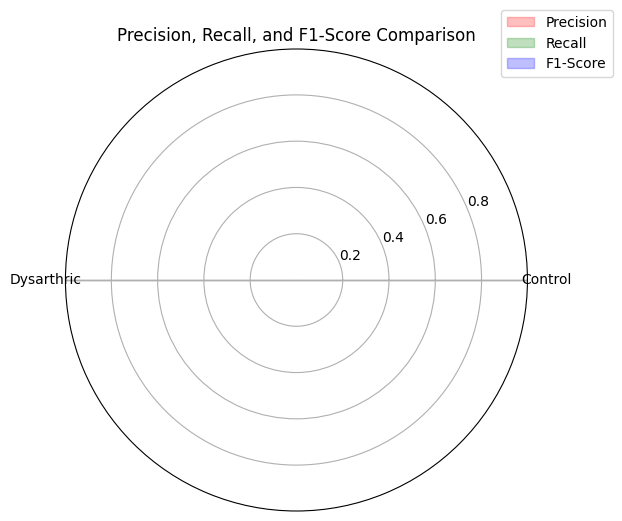

In [58]:
print("\nPreparing Feature Vectors")
X, y = prepare_feature_vectors(audio_files, labels)  # Replace with actual feature extraction function
print(f"Feature matrix shape: {X.shape}")
print(f"Labels shape: {y.shape}")

# Ensure tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

print("\nTraining CNN Model")
model, report, conf_matrix, acc, precision, recall, f1 = train_cnn_model(X, y)

print("\nClassification Report:")
print(report)

plot_confusion_matrix(conf_matrix, ["Control", "Dysarthric"])

# Bar Chart Visualization
metrics = {
    "accuracy": [acc],
    "f1_score": [f1],
}
techniques = ["CNN"]
plot_bar_chart(metrics, techniques)

# Radar Chart Visualization
precision_per_class = [precision_score(y, model(torch.tensor(X)).argmax(1).cpu(), average=None)]
recall_per_class = [recall_score(y, model(torch.tensor(X)).argmax(1).cpu(), average=None)]
f1_per_class = [f1_score(y, model(torch.tensor(X)).argmax(1).cpu(), average=None)]

plot_radar_chart(precision_per_class[0].tolist(), recall_per_class[0].tolist(), f1_per_class[0].tolist(), ["Control", "Dysarthric"])

In [59]:
# ============ Step 7: RNN model ============

class SimpleRNN(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, output_dim=2):
        super(SimpleRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension
        x, _ = self.rnn(x)
        x = x[:, -1, :]  # Take the last hidden state
        x = self.fc(x)
        return x

In [60]:
def train_rnn_model(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleRNN(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training RNN Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    acc = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average='macro')
    recall = recall_score(all_true, all_preds, average='macro')
    f1 = f1_score(all_true, all_preds, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)

    return model, class_report, conf_matrix, acc, precision, recall, f1

In [61]:
# # Plot confusion matrix
# def plot_confusion_matrix(conf_matrix, class_names):
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()

# # Bar Chart for Metrics Comparison
# def plot_bar_chart(metrics, techniques):
#     plt.figure(figsize=(10, 6))
#     x = np.arange(len(techniques))
#     width = 0.2

#     plt.bar(x - width, metrics['accuracy'], width, label='Accuracy')
#     plt.bar(x, metrics['f1_score'], width, label='F1-Score')

#     plt.xticks(x, techniques)
#     plt.ylabel('Score')
#     plt.title('Accuracy and F1-Score Comparison')
#     plt.legend()
#     plt.show()

# # Radar Chart for Precision, Recall, F1-Score
# def plot_radar_chart(precision, recall, f1, class_names):
#     angles = np.linspace(0, 2 * np.pi, len(class_names), endpoint=False).tolist()
#     angles += angles[:1]  # Close the loop

#     precision += precision[:1]
#     recall += recall[:1]
#     f1 += f1[:1]

#     fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

#     ax.fill(angles, precision, color="r", alpha=0.25, label="Precision")
#     ax.fill(angles, recall, color="g", alpha=0.25, label="Recall")
#     ax.fill(angles, f1, color="b", alpha=0.25, label="F1-Score")

#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(class_names)
#     ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
#     plt.title("Precision, Recall, and F1-Score Comparison")
#     plt.show()

Loading Audio Files


Processing Directories:   0%|          | 0/4 [00:00<?, ?it/s]
Scanning F_Con: 0it [00:00, ?it/s]
                                  
Scanning F_Con:   0%|          | 0/387 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/390 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/208 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/164 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/400 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/269 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/405 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/256 [00:00<?, ?it/s]
                            

Total audio files found: 17635

Preparing Feature Vectors


Extracting MFCC Features:  13%|█▎        | 2324/17635 [00:29<02:53, 88.32it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Extracting MFCC Features:  29%|██▉       | 5177/17635 [01:05<01:58, 104.75it/s]<ipython-input-52-d646d60f1af5>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting MFCC Features:  29%|██▉       | 5201/17635 [01:06<01:53, 109.24it/s]

Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 
Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


Extracting MFCC Features:  94%|█████████▍| 16606/17635 [03:28<00:21, 47.43it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=939
  warnings.warn(
Extracting MFCC Features:  94%|█████████▍| 16629/17635 [03:28<00:22, 45.55it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=134
  warnings.warn(
Extracting MFCC Features:  95%|█████████▍| 16671/17635 [03:29<00:20, 47.15it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=421
  warnings.warn(
Extracting MFCC Features:  95%|█████████▍| 16677/17635 [03:29<00:19, 49.05it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=155
  warnings.warn(
Extracting MFCC Features:  95%|█████████▍| 16683/17635 [03:29<00


Training RNN Model


Training RNN Model: 100%|██████████| 50/50 [01:31<00:00,  1.83s/it]


Accuracy: 0.9711
Precision: 0.9667
Recall: 0.9701
F1-Score: 0.9684

Classification Report:
              precision    recall  f1-score   support

     Control       0.98      0.97      0.98      2291
  Dysarthric       0.95      0.97      0.96      1236

    accuracy                           0.97      3527
   macro avg       0.97      0.97      0.97      3527
weighted avg       0.97      0.97      0.97      3527



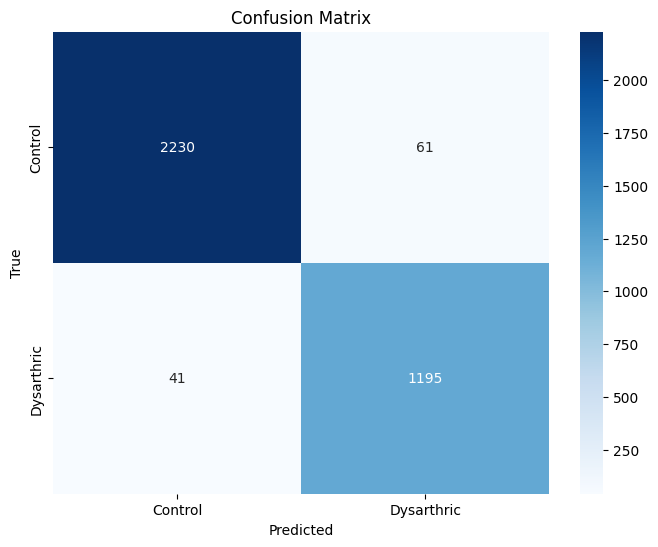

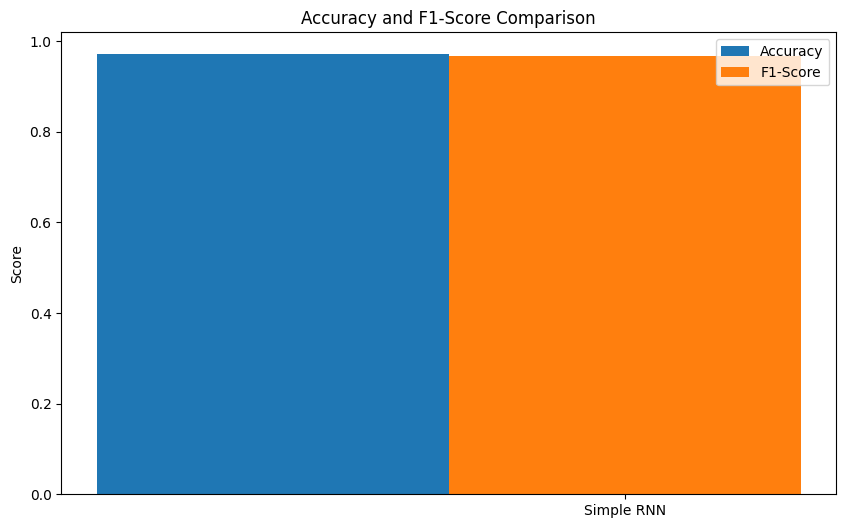

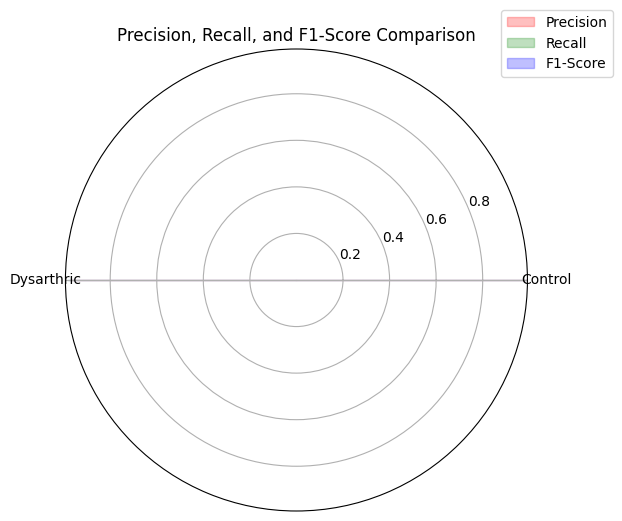

In [62]:
# Load and process data
print("Loading Audio Files")
audio_files, labels = load_audio_files(base_path)
print(f"Total audio files found: {len(audio_files)}")

print("\nPreparing Feature Vectors")
X, y = prepare_feature_vectors(audio_files, labels)  # Replace with actual function
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Train and evaluate RNN model
print("\nTraining RNN Model")
rnn_model, rnn_report, rnn_conf_matrix, rnn_acc, rnn_precision, rnn_recall, rnn_f1 = train_rnn_model(X, y)

print("\nClassification Report:")
print(rnn_report)

# Plot confusion matrix
plot_confusion_matrix(rnn_conf_matrix, ['Control', 'Dysarthric'])

# Metrics visualization
metrics = {
    "accuracy": [rnn_acc],
    "f1_score": [rnn_f1],
}
techniques = ["Simple RNN"]
plot_bar_chart(metrics, techniques)

# Radar Chart Visualization
precision_per_class = precision_score(y, rnn_model(X).argmax(1), average=None)
recall_per_class = recall_score(y, rnn_model(X).argmax(1), average=None)
f1_per_class = f1_score(y, rnn_model(X).argmax(1), average=None)

plot_radar_chart(precision_per_class.tolist(), recall_per_class.tolist(), f1_per_class.tolist(), ["Control", "Dysarthric"])

In [63]:
class SimpleLSTM(nn.Module):
    def __init__(self, input_dim=40, hidden_dim=128, output_dim=2):
        super(SimpleLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_dim, hidden_size=hidden_dim, num_layers=2, batch_first=True)
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),  # Fully connected layer
            nn.ReLU(),
            nn.Linear(64, output_dim)  # Output layer
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add sequence length dimension
        x, _ = self.lstm(x)  # LSTM outputs
        x = x[:, -1, :]  # Take the last hidden state
        x = self.fc(x)  # Fully connected layers
        return x

In [64]:
# Train and evaluate the LSTM model
def train_lstm_model(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = SimpleLSTM(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training LSTM Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average='macro')
    recall = recall_score(all_true, all_preds, average='macro')
    f1 = f1_score(all_true, all_preds, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)

    return model, class_report, conf_matrix, acc, precision, recall, f1

In [65]:
# # Plot confusion matrix
# def plot_confusion_matrix(conf_matrix, class_names):
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()

# # Bar Chart for Accuracy and F1-Score
# def plot_bar_chart(metrics, techniques):
#     plt.figure(figsize=(10, 6))
#     x = np.arange(len(techniques))
#     width = 0.3

#     plt.bar(x - width/2, metrics['accuracy'], width, label='Accuracy')
#     plt.bar(x + width/2, metrics['f1_score'], width, label='F1-Score')

#     plt.xticks(x, techniques)
#     plt.ylabel('Score')
#     plt.title('Accuracy and F1-Score Comparison')
#     plt.legend()
#     plt.show()

# # Radar Chart for Class-Level Precision, Recall, and F1-Score
# def plot_radar_chart(precision, recall, f1, class_names):
#     angles = np.linspace(0, 2 * np.pi, len(class_names), endpoint=False).tolist()
#     angles += angles[:1]  # Close the loop

#     precision += precision[:1]
#     recall += recall[:1]
#     f1 += f1[:1]

#     fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))

#     ax.fill(angles, precision, color="r", alpha=0.25, label="Precision")
#     ax.fill(angles, recall, color="g", alpha=0.25, label="Recall")
#     ax.fill(angles, f1, color="b", alpha=0.25, label="F1-Score")

#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(class_names)
#     ax.legend(loc='upper right')
#     plt.title("Precision, Recall, and F1-Score Comparison")
#     plt.show()

Loading Audio Files


Processing Directories:   0%|          | 0/4 [00:00<?, ?it/s]
Scanning F_Con: 0it [00:00, ?it/s]
                                  
Scanning F_Con:   0%|          | 0/387 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/390 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/208 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/164 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/400 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/269 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/405 [00:00<?, ?it/s]
                                                       
Scanning F_Con:   0%|          | 0/256 [00:00<?, ?it/s]
                            

Total audio files found: 17635

Preparing Feature Vectors


Extracting MFCC Features:  13%|█▎        | 2324/17635 [00:29<02:45, 92.58it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=0
  warnings.warn(
Extracting MFCC Features:  29%|██▉       | 5177/17635 [01:05<02:01, 102.76it/s]<ipython-input-52-d646d60f1af5>:3: UserWarning: PySoundFile failed. Trying audioread instead.
  y, sr = librosa.load(file_path, sr=sr, duration=duration)
/usr/local/lib/python3.10/dist-packages/librosa/core/audio.py:184: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)
Extracting MFCC Features:  29%|██▉       | 5201/17635 [01:06<01:54, 108.61it/s]

Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0067.wav: 
Error processing /root/.cache/kagglehub/datasets/pranaykoppula/torgo-audio/versions/1/F_Dys/wav_headMic_F01/wav_headMic_F01_0068.wav: 


Extracting MFCC Features:  94%|█████████▍| 16601/17635 [03:24<00:11, 91.29it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=939
  warnings.warn(
Extracting MFCC Features:  94%|█████████▍| 16631/17635 [03:25<00:10, 92.92it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=134
  warnings.warn(
Extracting MFCC Features:  95%|█████████▍| 16671/17635 [03:25<00:10, 93.40it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=421
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=2048 is too large for input signal of length=155
  warnings.warn(
Extracting MFCC Features:  95%|█████████▍| 16681/17635 [03:25<00:10, 94.13it/s]/usr/local/lib/python3.10/dist-packages/librosa/core/spectrum.py


Training LSTM Model


Training LSTM Model: 100%|██████████| 50/50 [03:22<00:00,  4.05s/it]


Accuracy: 0.9790
Precision: 0.9785
Recall: 0.9753
F1-Score: 0.9769

Classification Report:
              precision    recall  f1-score   support

     Control       0.98      0.99      0.98      2291
  Dysarthric       0.98      0.96      0.97      1236

    accuracy                           0.98      3527
   macro avg       0.98      0.98      0.98      3527
weighted avg       0.98      0.98      0.98      3527



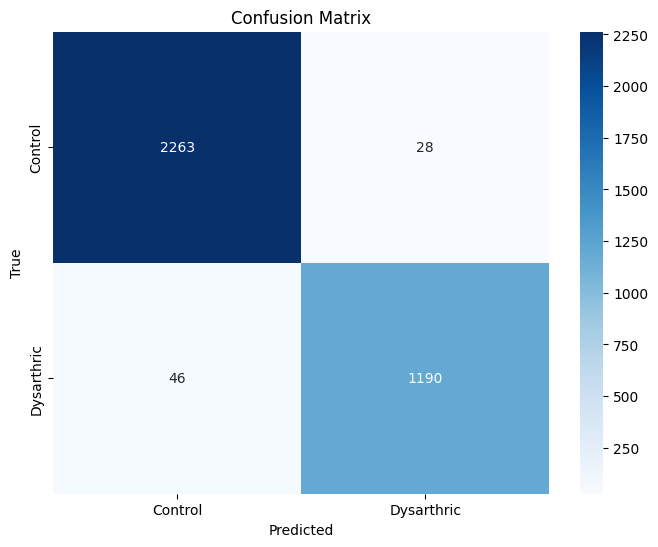

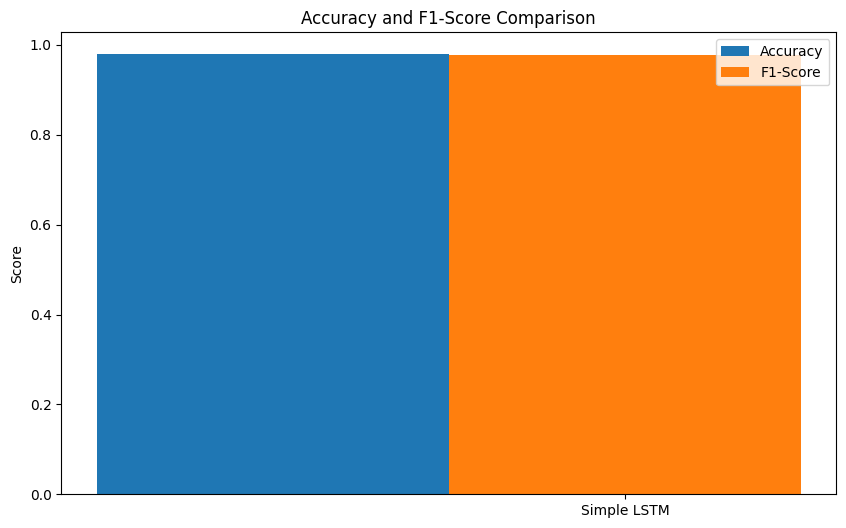

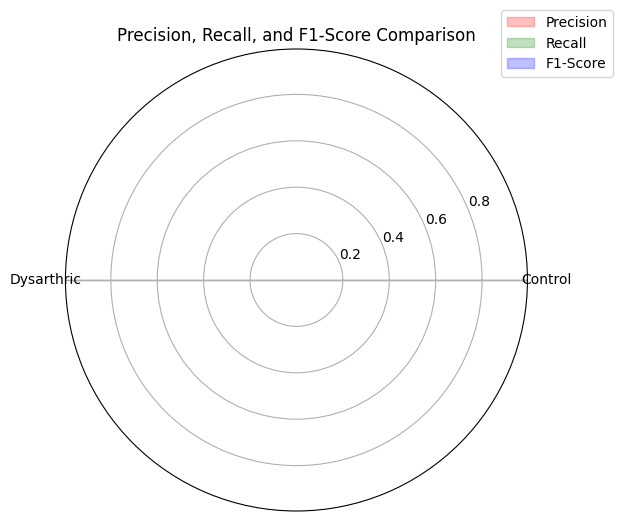

In [66]:
print("Loading Audio Files")
audio_files, labels = load_audio_files(base_path)  # Replace with actual function
print(f"Total audio files found: {len(audio_files)}")

print("\nPreparing Feature Vectors")
X, y = prepare_feature_vectors(audio_files, labels)  # Replace with actual function
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.long)

# Train and evaluate LSTM model
print("\nTraining LSTM Model")
lstm_model, lstm_report, lstm_conf_matrix, acc, precision, recall, f1 = train_lstm_model(X, y)

print("\nClassification Report:")
print(lstm_report)

# Plot confusion matrix
plot_confusion_matrix(lstm_conf_matrix, ['Control', 'Dysarthric'])

# Metrics visualization
metrics = {
    "accuracy": [acc],
    "f1_score": [f1],
}
techniques = ["Simple LSTM"]
plot_bar_chart(metrics, techniques)

# Radar Chart Visualization
precision_per_class = precision_score(y, lstm_model(X).argmax(1), average=None)
recall_per_class = recall_score(y, lstm_model(X).argmax(1), average=None)
f1_per_class = f1_score(y, lstm_model(X).argmax(1), average=None)

plot_radar_chart(precision_per_class.tolist(), recall_per_class.tolist(), f1_per_class.tolist(), ["Control", "Dysarthric"])

In [67]:
# Hybrid CNN-LSTM Model
class HybridCNNLSTM(nn.Module):
    def __init__(self, input_dim=40, cnn_output_dim=32, lstm_hidden_dim=128, output_dim=2):
        super(HybridCNNLSTM, self).__init__()

        # CNN layers
        self.conv1 = nn.Conv1d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv1d(16, cnn_output_dim, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(2, 2)
        self.relu = nn.ReLU()

        # LSTM layers
        self.lstm = nn.LSTM(input_size=cnn_output_dim, hidden_size=lstm_hidden_dim, num_layers=2, batch_first=True)

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(lstm_hidden_dim, 64),
            nn.ReLU(),
            nn.Linear(64, output_dim)
        )

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension: (batch_size, 1, feature_dim)
        x = self.pool(self.relu(self.conv1(x)))  # Conv1 + Pooling
        x = self.pool(self.relu(self.conv2(x)))  # Conv2 + Pooling

        x = x.permute(0, 2, 1)  # Reshape for LSTM: (batch_size, seq_len, feature_dim)
        x, _ = self.lstm(x)  # LSTM output
        x = x[:, -1, :]  # Take last hidden state
        x = self.fc(x)  # Fully connected layers
        return x

In [68]:
# Train and evaluate the Hybrid CNN-LSTM model
def train_hybrid_model(X, y, test_size=0.2, random_state=42):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    model = HybridCNNLSTM(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training loop
    num_epochs = 50
    for epoch in tqdm(range(num_epochs), desc="Training Hybrid CNN-LSTM Model"):
        model.train()
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluation
    model.eval()
    all_preds = []
    all_true = []
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(batch_y.cpu().numpy())

    # Calculate metrics
    acc = accuracy_score(all_true, all_preds)
    precision = precision_score(all_true, all_preds, average='macro')
    recall = recall_score(all_true, all_preds, average='macro')
    f1 = f1_score(all_true, all_preds, average='macro')

    print(f"Accuracy: {acc:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")

    class_names = ['Control', 'Dysarthric']
    class_report = classification_report(all_true, all_preds, target_names=class_names)
    conf_matrix = confusion_matrix(all_true, all_preds)

    return model, class_report, conf_matrix, acc, precision, recall, f1

In [69]:
# # Plot confusion matrix
# def plot_confusion_matrix(conf_matrix, class_names):
#     plt.figure(figsize=(8, 6))
#     sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='Blues')
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()

# # Bar Chart for Accuracy and F1-Score
# def plot_bar_chart(metrics, techniques):
#     plt.figure(figsize=(10, 6))
#     x = np.arange(len(techniques))
#     width = 0.3

#     plt.bar(x - width/2, metrics['accuracy'], width, label='Accuracy')
#     plt.bar(x + width/2, metrics['f1_score'], width, label='F1-Score')

#     plt.xticks(x, techniques)
#     plt.ylabel('Score')
#     plt.title('Accuracy and F1-Score Comparison')
#     plt.legend()
#     plt.show()

# # Radar Chart for Class-Level Precision, Recall, and F1-Score
# def plot_radar_chart(precision, recall, f1, class_names):
#     angles = np.linspace(0, 2 * np.pi, len(class_names), endpoint=False).tolist()
#     angles += angles[:1]

#     precision += precision[:1]
#     recall += recall[:1]
#     f1 += f1[:1]

#     fig, ax = plt.subplots(figsize=(6, 6), subplot_kw=dict(polar=True))
#     ax.fill(angles, precision, color='r', alpha=0.25, label='Precision')
#     ax.fill(angles, recall, color='g', alpha=0.25, label='Recall')
#     ax.fill(angles, f1, color='b', alpha=0.25, label='F1-Score')

#     ax.set_xticks(angles[:-1])
#     ax.set_xticklabels(class_names)
#     plt.legend()
#     plt.title("Precision, Recall, and F1-Score")
#     plt.show()


Training Hybrid CNN-LSTM Model


Training Hybrid CNN-LSTM Model: 100%|██████████| 50/50 [09:17<00:00, 11.16s/it]


Accuracy: 0.9691
Precision: 0.9689
Recall: 0.9630
F1-Score: 0.9658

Classification Report:
              precision    recall  f1-score   support

     Control       0.97      0.98      0.98      2291
  Dysarthric       0.97      0.94      0.96      1236

    accuracy                           0.97      3527
   macro avg       0.97      0.96      0.97      3527
weighted avg       0.97      0.97      0.97      3527



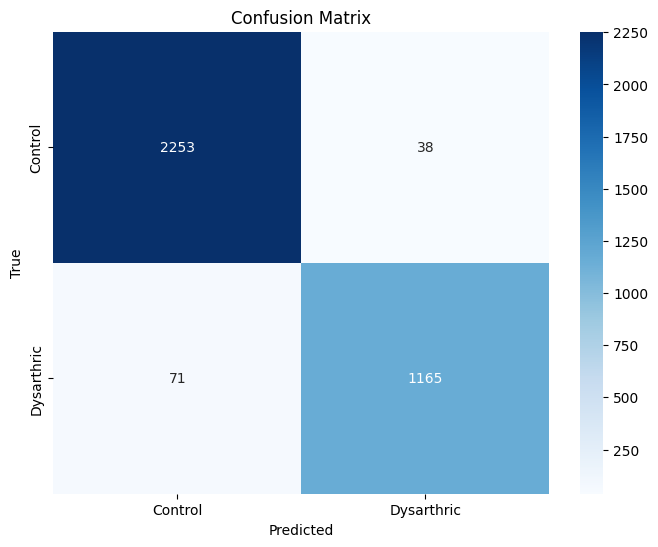

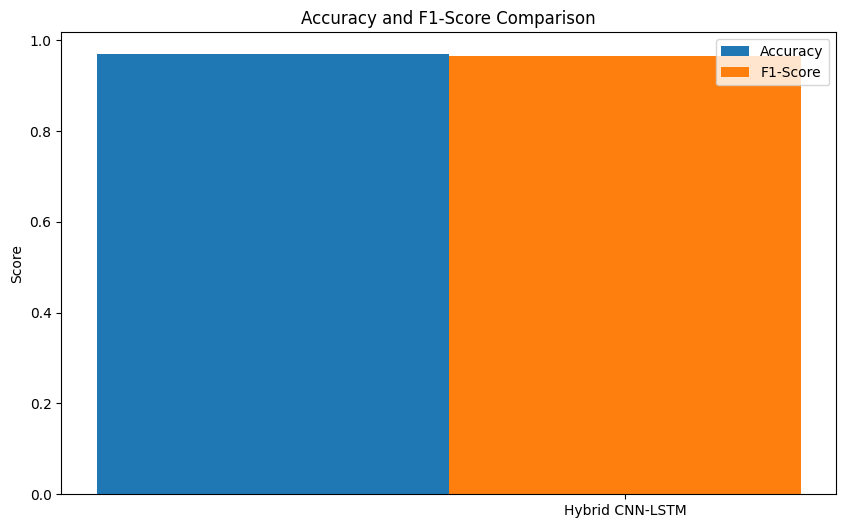

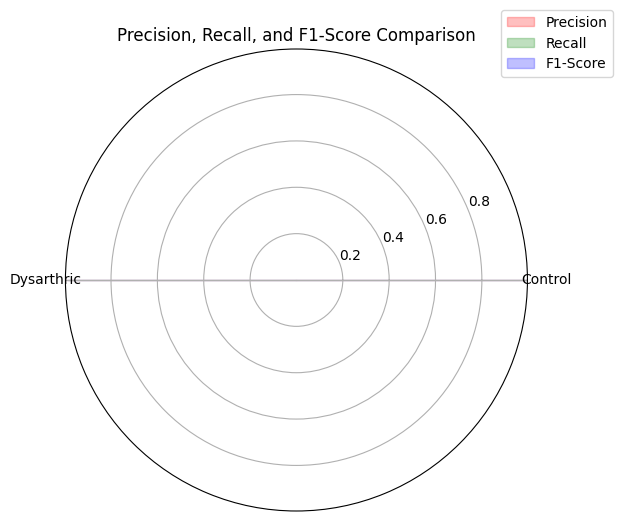

In [70]:
print("\nTraining Hybrid CNN-LSTM Model")
hybrid_model, hybrid_report, hybrid_conf_matrix, acc, precision, recall, f1 = train_hybrid_model(X, y)

# Display report and confusion matrix
print("\nClassification Report:")
print(hybrid_report)

plot_confusion_matrix(hybrid_conf_matrix, ['Control', 'Dysarthric'])

# Plot performance bar chart
metrics = {'accuracy': [acc], 'f1_score': [f1]}
plot_bar_chart(metrics, ['Hybrid CNN-LSTM'])

# Radar chart for class-level metrics
precision_per_class = precision_score(y, hybrid_model(X).argmax(1), average=None)
recall_per_class = recall_score(y, hybrid_model(X).argmax(1), average=None)
f1_per_class = f1_score(y, hybrid_model(X).argmax(1), average=None)

plot_radar_chart(precision_per_class.tolist(), recall_per_class.tolist(), f1_per_class.tolist(), ['Control', 'Dysarthric'])